## MP2: Red & White Wine

In [2]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from descriptive_stats import ct, dp, cr, vs
from utils.data_loader import load_excel, merge_wine_data, remove_missing, remove_duplicates

### Data Loading

In [4]:
xlsx_file_path = '../Data/winequality-red.xlsx'
df_red = load_excel(xlsx_file_path)

In [5]:
xlsx_file_path = '../Data/winequality-white.xlsx'
df_white = load_excel(xlsx_file_path)

In [6]:
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [7]:
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [8]:
df_red.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
remove_missing(df_red)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [10]:
df_white.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
remove_missing(df_white)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [12]:
wine_df = merge_wine_data(df_red, df_white)

In [13]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


### Data Exploration

In [15]:
print("Red Wines:")
df_red.info()

print("\nWhite Wines:")
df_white.info()

print("\nCombined data:")
wine_df.info()

Red Wines:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  type                  1599 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB

White Wines:
<class 'pandas.core.frame.DataFrame'>


In [16]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 5.
Transform the categorical data into numeric, applying appropriate encoding methods.

In [18]:

wine_df['type'] = wine_df['type'].map({'red': 0, 'white': 1})

In [19]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


### 6.
Calculate the descriptive statistics of the numeric data. Check whether the distribution of
the values of the attributes is normal.

In [21]:
# Descriptive statistics - not sure if this is what is ment?
print(wine_df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

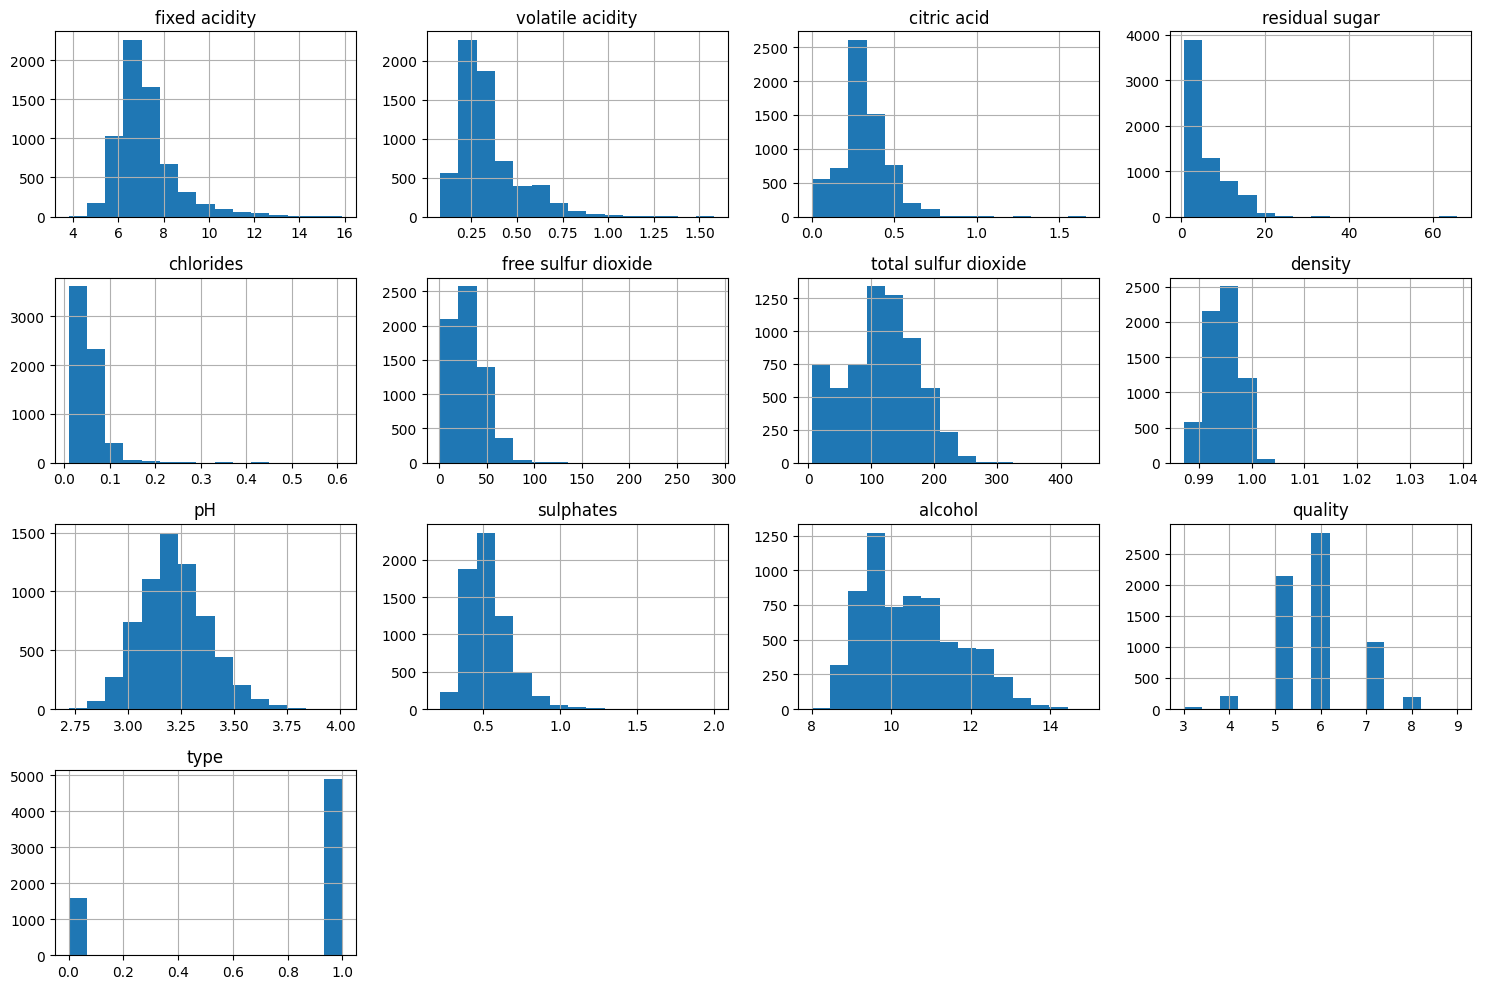

In [22]:
#smaller scale histogram
wine_df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show() 

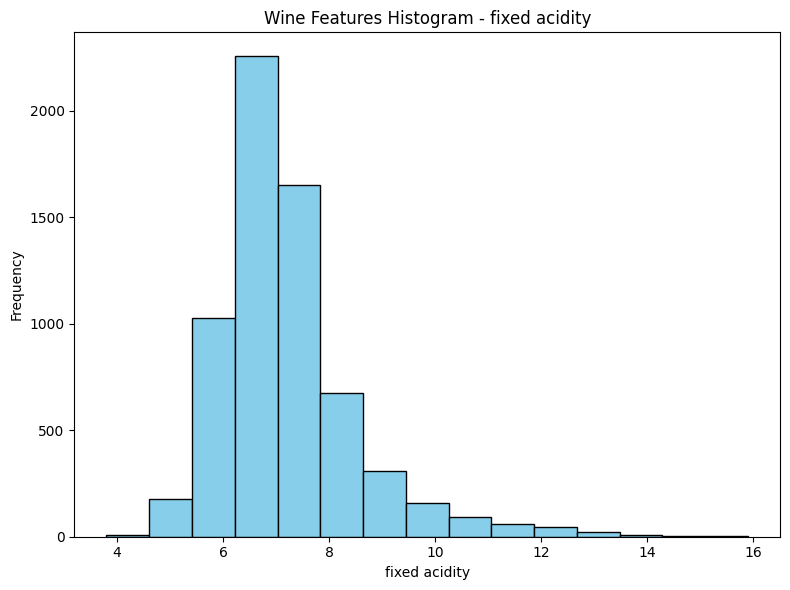

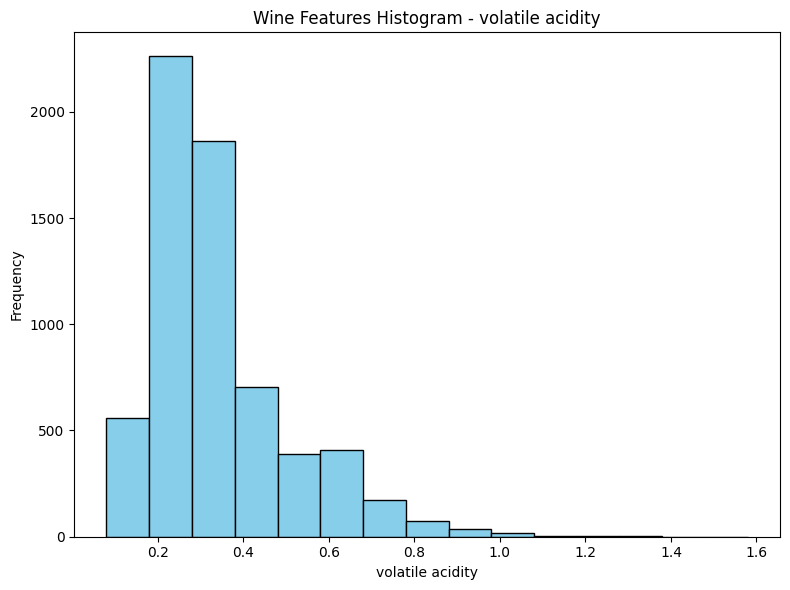

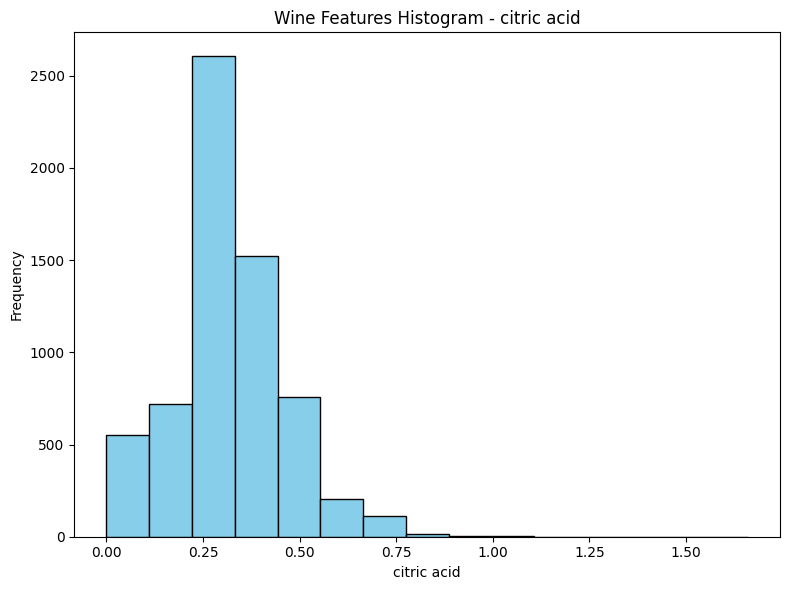

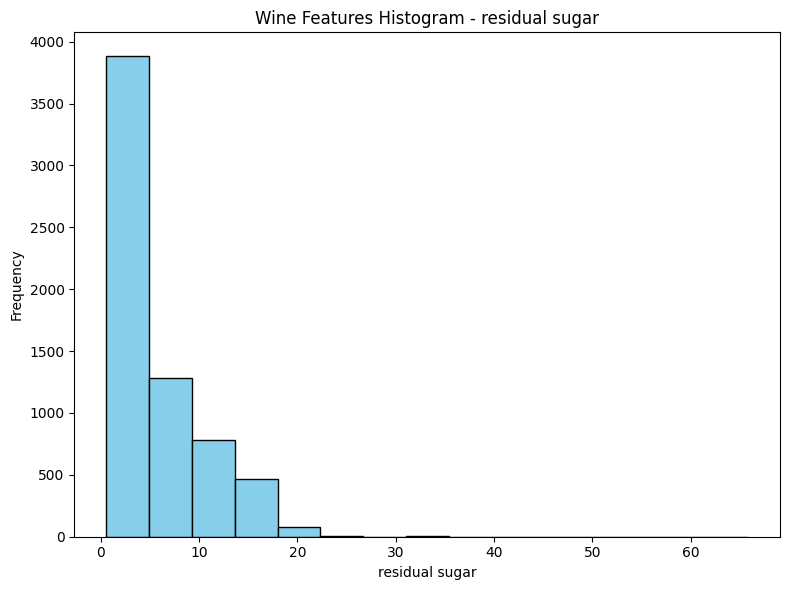

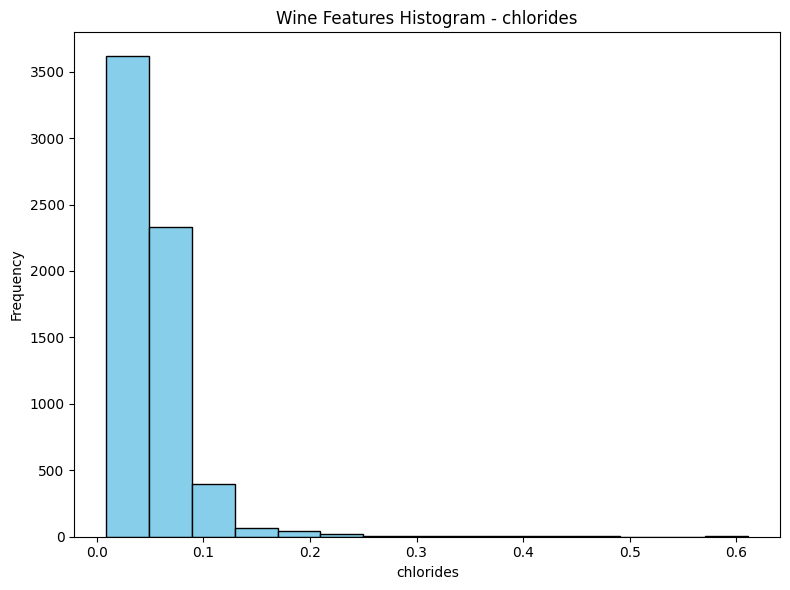

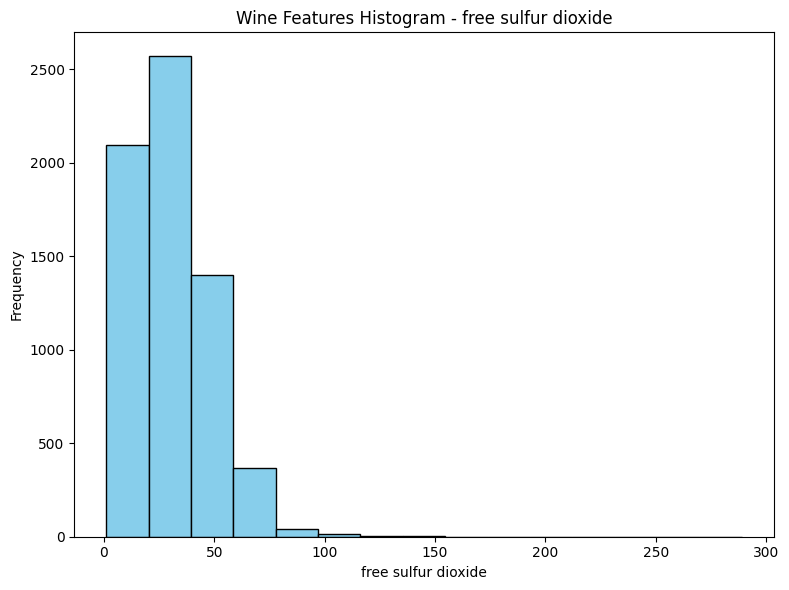

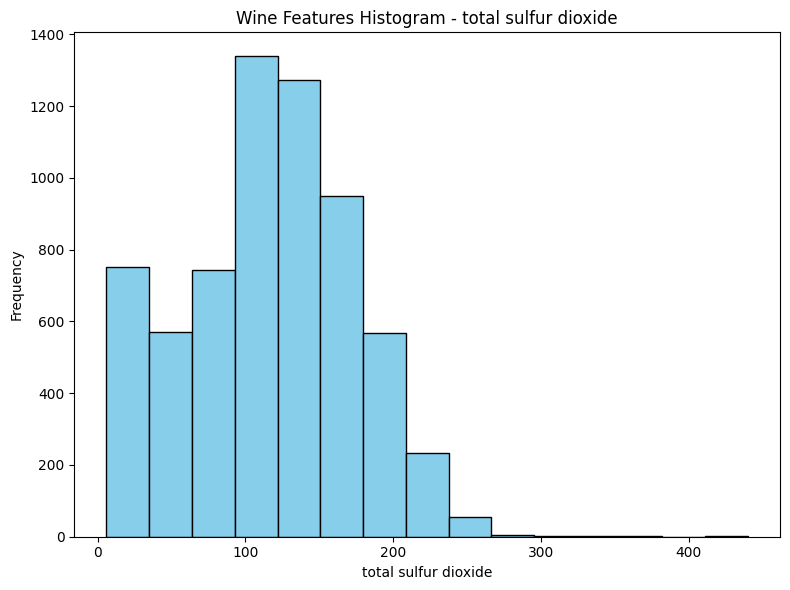

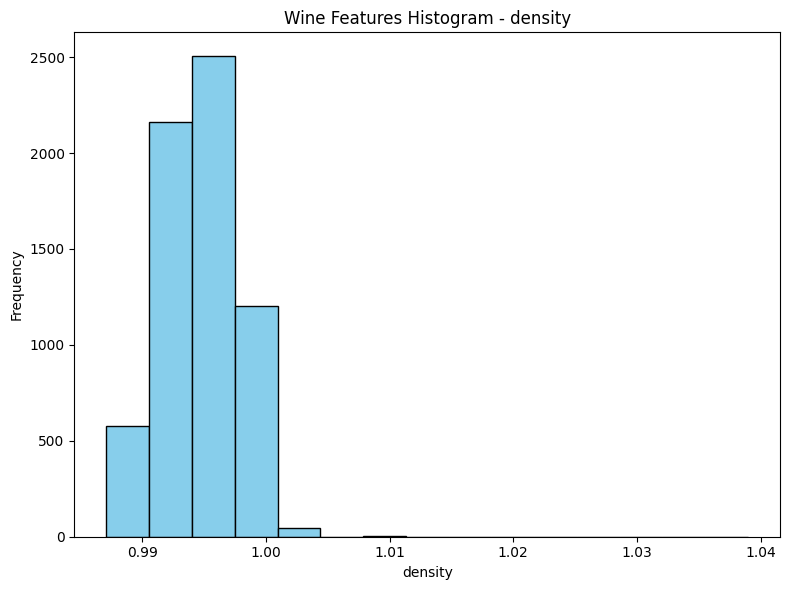

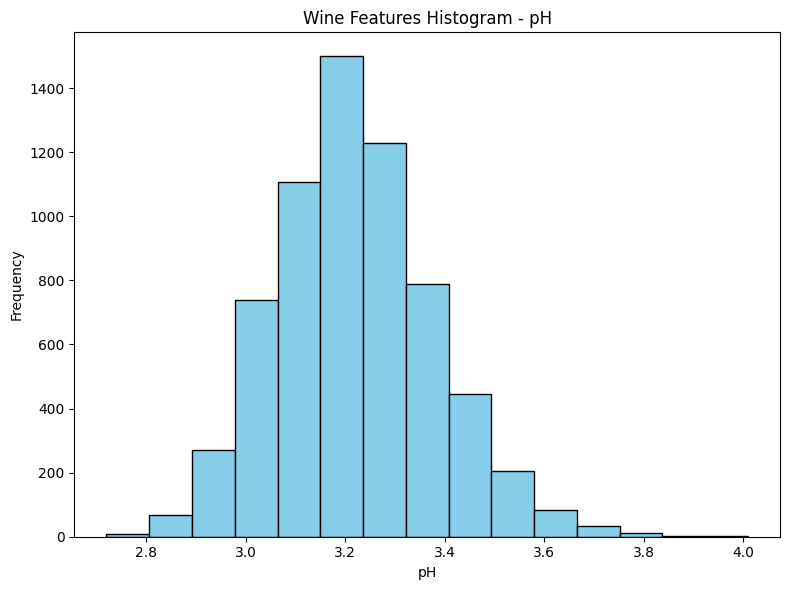

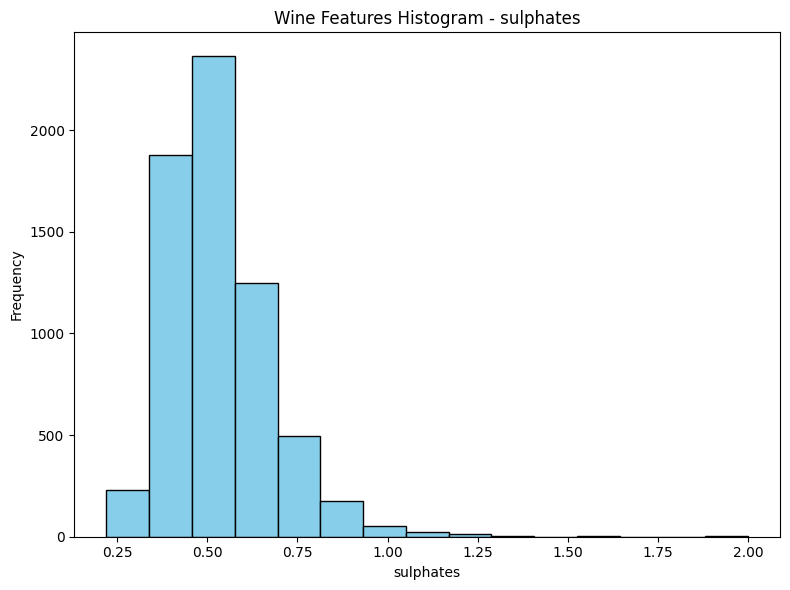

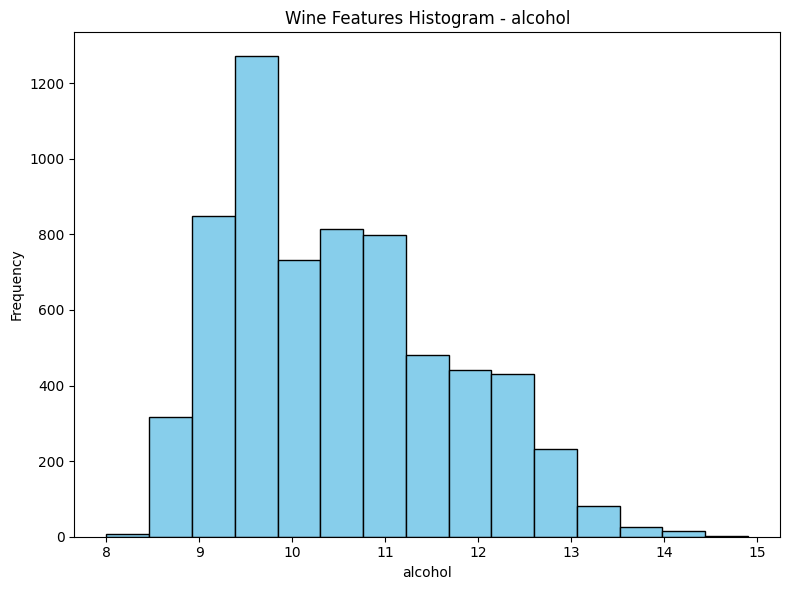

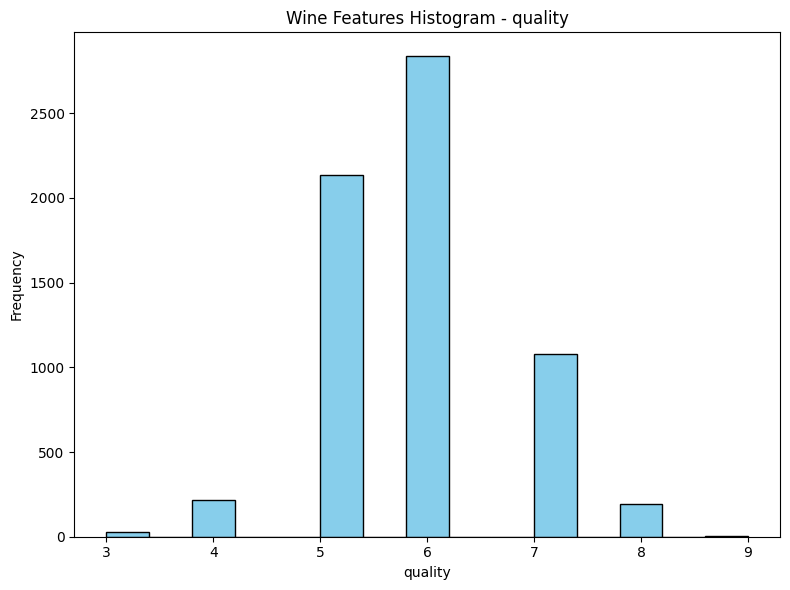

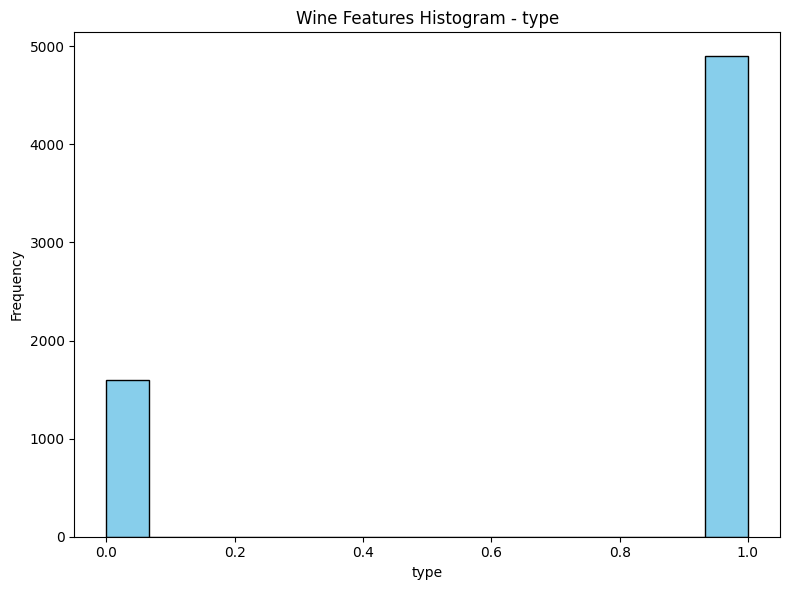

In [23]:
# Huge scaling, but otherwise i cant see the numbers
vs.histogram(wine_df, title='Wine Features Histogram')

In [24]:
#tells you if the distribution is asymmetric. 
#A value of 0 means perfectly symmetric, positive skewness means the right tail is longer, and negative skewness means the left tail is longer.
wine_df.skew()

fixed acidity           1.723290
volatile acidity        1.495097
citric acid             0.471731
residual sugar          1.435404
chlorides               5.399828
free sulfur dioxide     1.220066
total sulfur dioxide   -0.001177
density                 0.503602
pH                      0.386839
sulphates               1.797270
alcohol                 0.565718
quality                 0.189623
type                   -1.179095
dtype: float64

In [25]:
# tells you how heavy or light the tails of the distribution are compared to a normal distribution.
# A kurtosis greater than 3 indicates heavy tails (more outliers), while less than 3 means lighter tails.
wine_df.kurtosis()

fixed acidity            5.061161
volatile acidity         2.825372
citric acid              2.397239
residual sugar           4.359272
chlorides               50.898051
free sulfur dioxide      7.906238
total sulfur dioxide    -0.371664
density                  6.606067
pH                       0.367657
sulphates                8.653699
alcohol                 -0.531687
quality                  0.232322
type                    -0.609922
dtype: float64

### 7. Diagrams

In [27]:
df_red_clean = remove_duplicates(df_red)

In [28]:
df_white_clean = remove_duplicates(df_white)

In [29]:
wine_df_clean = remove_duplicates(wine_df)

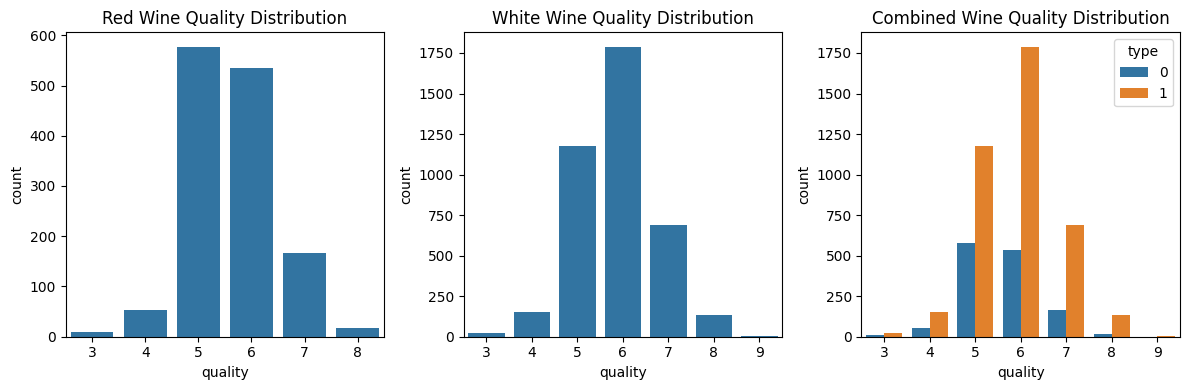

In [30]:
# Shows us a general overview of how many wines fall into each category of quality
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sbn.countplot(x='quality', data=df_red_clean)
plt.title('Red Wine Quality Distribution')

plt.subplot(1,3,2)
sbn.countplot(x='quality', data=df_white_clean)
plt.title('White Wine Quality Distribution')

plt.subplot(1,3,3)
sbn.countplot(x='quality', hue='type', data=wine_df_clean)
plt.title('Combined Wine Quality Distribution')

plt.tight_layout()
plt.show()

In [31]:
# Which type of wine has higher average quality?
mean_quality_red = wine_df_clean[wine_df_clean['type'] == 0]['quality'].mean()
mean_quality_white = wine_df_clean[wine_df_clean['type'] == 1]['quality'].mean()
difference = mean_quality_white - mean_quality_red
print(f"Red: {mean_quality_red:.2f}, White: {mean_quality_white:.2f}, Difference: {difference:.2f}")

Red: 5.62, White: 5.85, Difference: 0.23


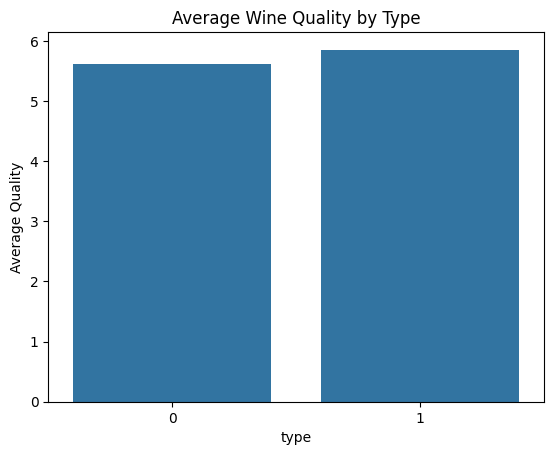

In [32]:
# Remember type 0 is Red and type 1 is White
avg_quality = wine_df_clean.groupby('type')['quality'].mean().reset_index()
sbn.barplot(x='type', y='quality', data=avg_quality)
plt.title('Average Wine Quality by Type')
plt.ylabel('Average Quality')
plt.show()

##### We now see that, once cleaned of missing values AND duplicates, white wines have a slightly higher average quality by 0.23

In [34]:
avg_alcohol = wine_df_clean.groupby('type')['alcohol'].mean()
print(avg_alcohol)

type
0    10.432315
1    10.589358
Name: alcohol, dtype: float64


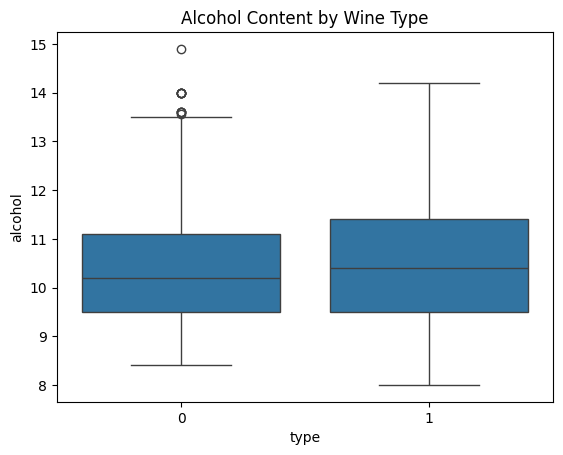

In [35]:
sbn.boxplot(x='type', y='alcohol', data=wine_df_clean)
plt.title('Alcohol Content by Wine Type')
plt.show()

##### We can see that white wine has a higher average alchohol content with 10.5893 vs red wine at 10.4323, with a few small outliers for red wine

In [37]:
avg_sugar = wine_df_clean.groupby('type')['residual sugar'].mean()
print(avg_sugar)

type
0    2.523400
1    5.914819
Name: residual sugar, dtype: float64


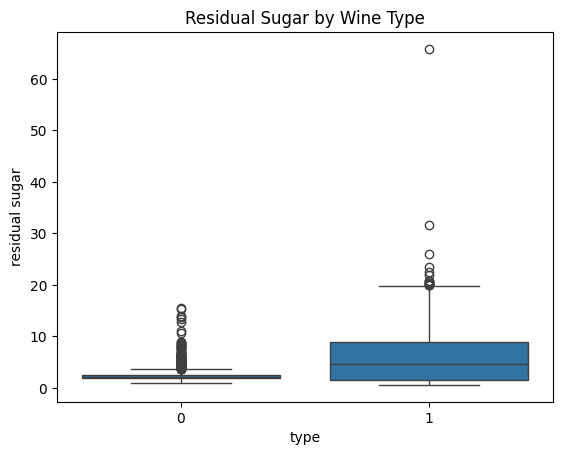

In [38]:
sbn.boxplot(x='type', y='residual sugar', data=wine_df_clean)
plt.title('Residual Sugar by Wine Type')
plt.show()

##### We see that white wine a significantly higher average residual sugar content at 5.9148 compared to red wine at 2.5234.
##### However, we also see from the boxplot that there is one massive outlier from the white wine datasheet

In [40]:
# Let's find this one obvious mega outlier
white_wine = wine_df_clean[wine_df_clean['type'] == 1].copy()
max_sugar_index = white_wine['residual sugar'].idxmax()

# Let's see the outlier itself
outlier_row = wine_df_clean.loc[max_sugar_index]
print("Outlier row with highest residual sugar (white wine):")
print(outlier_row)

Outlier row with highest residual sugar (white wine):
fixed acidity             7.80000
volatile acidity          0.96500
citric acid               0.60000
residual sugar           65.80000
chlorides                 0.07400
free sulfur dioxide       8.00000
total sulfur dioxide    160.00000
density                   1.03898
pH                        3.39000
sulphates                 0.69000
alcohol                  11.70000
quality                   6.00000
type                      1.00000
Name: 4380, dtype: float64


In [41]:
wine_df_outlier_gone = wine_df_clean.drop(index=max_sugar_index)

In [42]:
# Now let's try again
avg_sugar = wine_df_outlier_gone.groupby('type')['residual sugar'].mean()
print(avg_sugar)

type
0    2.523400
1    5.899697
Name: residual sugar, dtype: float64


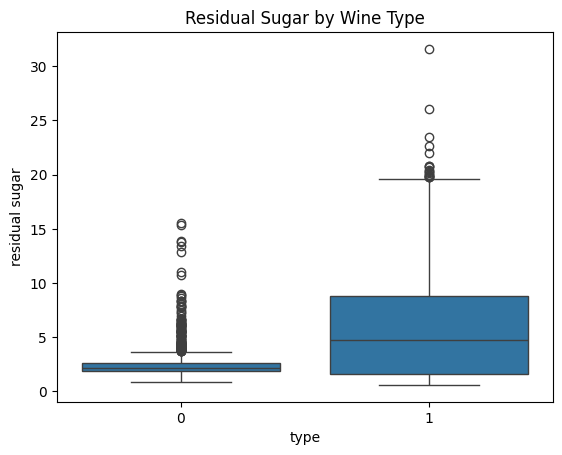

In [43]:
sbn.boxplot(x='type', y='residual sugar', data=wine_df_outlier_gone)
plt.title('Residual Sugar by Wine Type')
plt.show()

##### We see that white wine still has a significantly higher average residual sugar content at 5.8996 compared to red wine at 2.5234.
##### The biggest obvious outlier has been removed, yet other outliers remain from both types of wine (removing these should be discussed, yet it doesn't change that white wine is clearly with a higher sugar content overall). 

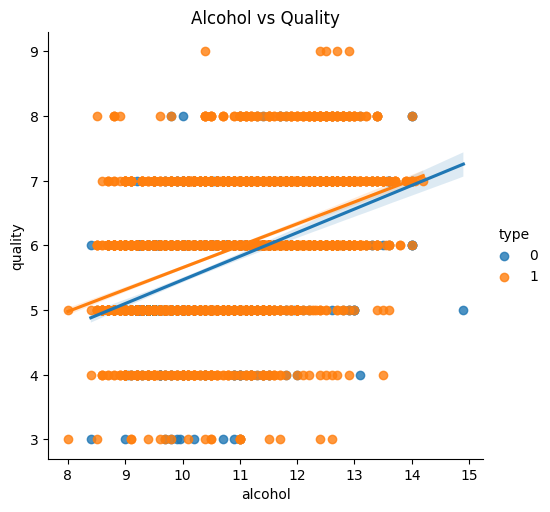

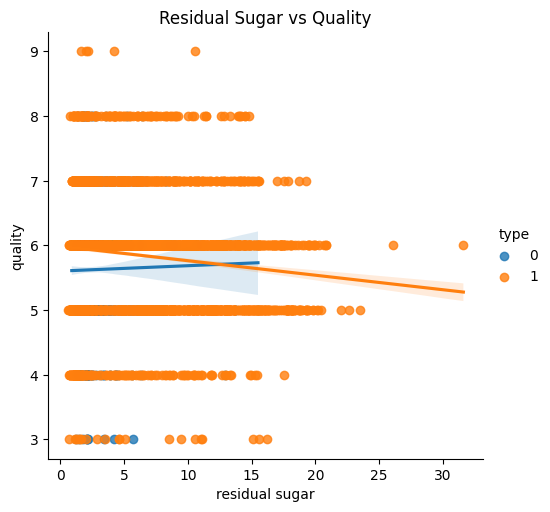

In [45]:
# Does the quantity of alcohol and residual sugar influence the quality of the wine?
sbn.lmplot(x='alcohol', y='quality', hue='type', data=wine_df_outlier_gone)
plt.title('Alcohol vs Quality')
plt.show()

sbn.lmplot(x='residual sugar', y='quality', hue='type', data=wine_df_outlier_gone)
plt.title('Residual Sugar vs Quality')
plt.show()

##### These scatterplots plot all the wines allowing us to see quality and compare these to either residual sugar or alchohol. The regression line indicates a trend and thus also gives an impression of whether there might be a positive or negative correlation

In [47]:
red_corr = wine_df_outlier_gone[wine_df_outlier_gone['type'] == 0][['alcohol', 'residual sugar', 'quality']].corr()
white_corr = wine_df_outlier_gone[wine_df_outlier_gone['type'] == 1][['alcohol', 'residual sugar', 'quality']].corr()
print("Red Wine Correlation:\n", red_corr)
print("White Wine Correlation:\n", white_corr)

Red Wine Correlation:
                  alcohol  residual sugar   quality
alcohol         1.000000        0.063281  0.480343
residual sugar  0.063281        1.000000  0.013640
quality         0.480343        0.013640  1.000000
White Wine Correlation:
                  alcohol  residual sugar   quality
alcohol         1.000000       -0.408962  0.462882
residual sugar -0.408962        1.000000 -0.120172
quality         0.462882       -0.120172  1.000000


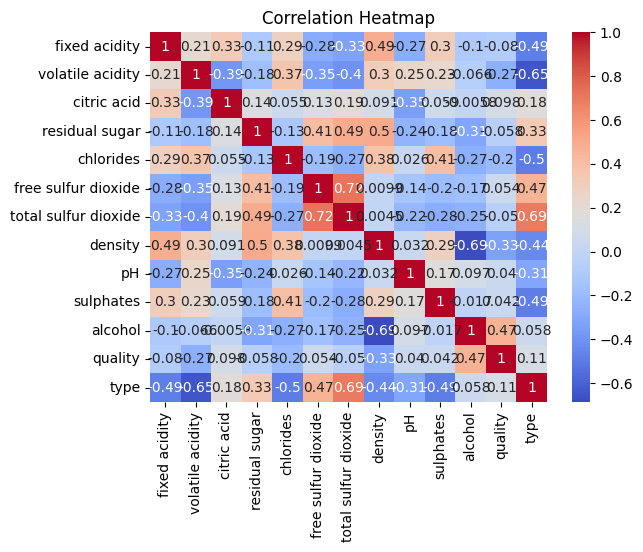

In [48]:
# A correlation heatmap for the entire dataframe containing both red and white wines
vs.correlation_heatmap(wine_df_outlier_gone)

##### We see that there's a positive correlation between alchohol content and quality for both red and white wine in our scatterplots, with it being only mildly more positive for red wine compared to white.
##### The correlation between residual sugar and quality however is not quite as apparent. White wine appears to have a slightly negative correlation while red wine looks barely positive BUT for red wine the correlation is uncertain enough that we can make a final conclusion based solely on diagrams.
##### However judging from the Pearson Correlation Matrices, knowing that 1 means a strong posititive correlation, -1 a strong negative and 0 no correlation, we can arrive at the following conclusion:

##### For red wine, with alchohol vs. quality correlation at 0.48, we have a moderate positive correlation - meaning more alchohol = better quality. Meanwhile with residual sugar vs. alchohol at only 0.014, there is pratically no correlation here.
##### For white wine, with alchohol vs. quality correlation at 0.46, we have a moderate positive correlation - meaning again more alchohol = better quality. However when it comes to residual sugar vs. quality at -0.12, we have a weak negative correlation - meaning quality drops slightly for white wines the more sugar is in it.

In [51]:
# Task 8: Discuss which other questions might be of interest for wine consumers and distributors

print("Questions of interest for wine consumers:")
print("1. Is there a relationship between price (if available) and quality?")
print("2. Which attributes most affect the taste profile that consumers prefer?")
print("3. Are there significant differences between red and white wines in terms of health attributes like alcohol content?")
print("4. Which wines offer the best quality-to-price ratio?")
print("5. Are organic/sustainable wines (if labeled) rated differently than conventional wines?")

print("\nQuestions of interest for wine distributors:")
print("1. Which chemical properties predict the shelf life and stability of wines?")
print("2. Is there a correlation between production cost factors and quality?")
print("3. Which attributes should be highlighted in marketing to different consumer segments?")
print("4. Are there seasonal variations in wine quality or preferences?")
print("5. How do transportation and storage conditions affect wine attributes and quality?")


Questions of interest for wine consumers:
1. Is there a relationship between price (if available) and quality?
2. Which attributes most affect the taste profile that consumers prefer?
3. Are there significant differences between red and white wines in terms of health attributes like alcohol content?
4. Which wines offer the best quality-to-price ratio?
5. Are organic/sustainable wines (if labeled) rated differently than conventional wines?

Questions of interest for wine distributors:
1. Which chemical properties predict the shelf life and stability of wines?
2. Is there a correlation between production cost factors and quality?
3. Which attributes should be highlighted in marketing to different consumer segments?
4. Are there seasonal variations in wine quality or preferences?
5. How do transportation and storage conditions affect wine attributes and quality?



Distribution of wines across pH categories:
pH_category
Very high acidity    1583
High acidity         3091
Medium acidity       1514
Low acidity           277
Very low acidity       30
Name: count, dtype: int64


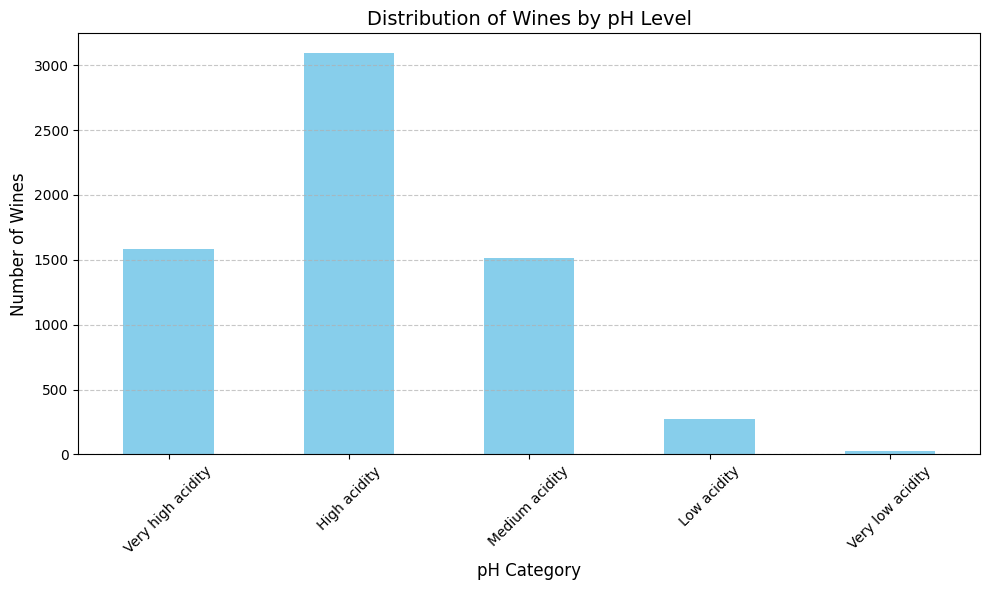


Mean quality by pH category:
pH_category
Very high acidity    5.785850
High acidity         5.810094
Medium acidity       5.884412
Low acidity          5.732852
Very low acidity     5.833333
Name: quality, dtype: float64


C:\Users\Toxic\AppData\Local\Temp\ipykernel_17256\1994454260.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quality_by_ph = wine_df.groupby('pH_category')['quality'].mean().sort_index()


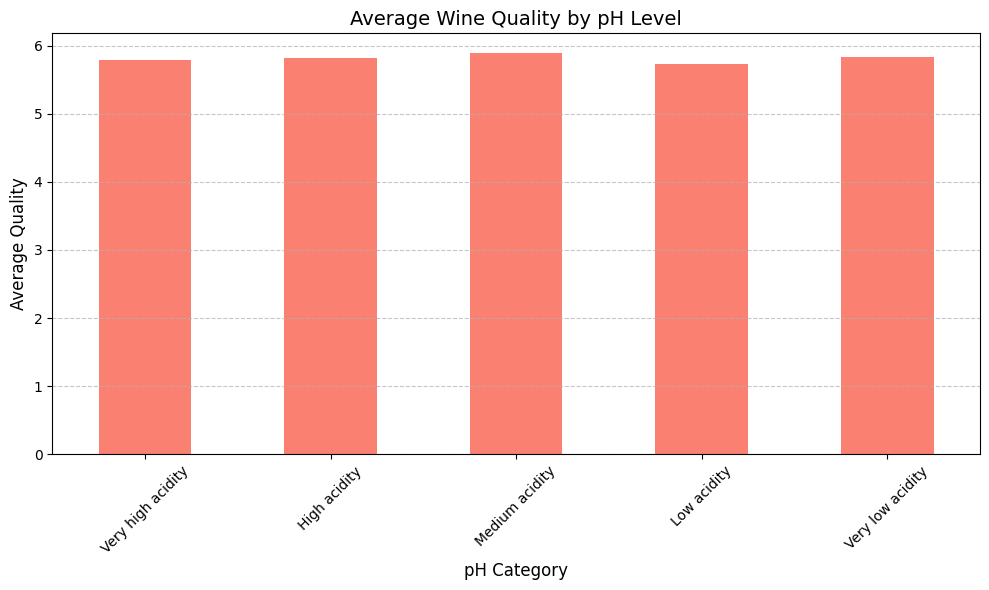


Key attributes by pH category:
                  alcohol volatile acidity residual sugar sulphates quality  \
                     mean             mean           mean      mean    mean   
pH_category                                                                   
Very high acidity   10.33             0.29           7.13      0.50    5.79   
High acidity        10.48             0.33           5.52      0.52    5.81   
Medium acidity      10.62             0.39           3.99      0.56    5.88   
Low acidity         10.80             0.46           3.23      0.60    5.73   
Very low acidity    11.51             0.41           2.54      0.60    5.83   

                                 
                  max min   std  
pH_category                      
Very high acidity   8   3  0.86  
High acidity        9   3  0.86  
Medium acidity      9   3  0.90  
Low acidity         8   3  0.96  
Very low acidity    8   4  0.99  

Mean density by pH category (highest to lowest):
pH_category
L

C:\Users\Toxic\AppData\Local\Temp\ipykernel_17256\1994454260.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attributes_by_ph = wine_df.groupby('pH_category').agg({
C:\Users\Toxic\AppData\Local\Temp\ipykernel_17256\1994454260.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_by_ph = wine_df.groupby('pH_category')['density'].mean().sort_values(ascending=False)
C:\Users\Toxic\AppData\Local\Temp\ipykernel_17256\1994454260.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

In [52]:
# Task 9: Split data into subsets by binning the pH attribute

# Define pH bins and labels
ph_bins = [2.7, 3.1, 3.3, 3.5, 3.7, 4.0]  # Adjust these ranges based on your data distribution
ph_labels = ['Very high acidity', 'High acidity', 'Medium acidity', 'Low acidity', 'Very low acidity']

# Create a new column with pH bins
wine_df['pH_category'] = pd.cut(wine_df['pH'], bins=ph_bins, labels=ph_labels)

# Display the distribution of wines across pH categories
ph_distribution = wine_df['pH_category'].value_counts().sort_index()
print("\nDistribution of wines across pH categories:")
print(ph_distribution)

# Create a bar plot of the pH distribution
plt.figure(figsize=(10, 6))
ph_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Wines by pH Level', fontsize=14)
plt.xlabel('pH Category', fontsize=12)
plt.ylabel('Number of Wines', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate mean quality for each pH category
quality_by_ph = wine_df.groupby('pH_category')['quality'].mean().sort_index()
print("\nMean quality by pH category:")
print(quality_by_ph)

# Create a bar plot of quality by pH category
plt.figure(figsize=(10, 6))
quality_by_ph.plot(kind='bar', color='salmon')
plt.title('Average Wine Quality by pH Level', fontsize=14)
plt.xlabel('pH Category', fontsize=12)
plt.ylabel('Average Quality', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze other attributes by pH category
attributes_by_ph = wine_df.groupby('pH_category').agg({
    'alcohol': 'mean',
    'volatile acidity': 'mean',
    'residual sugar': 'mean',
    'sulphates': 'mean',
    'quality': ['mean', 'max', 'min', 'std']
}).round(2)

print("\nKey attributes by pH category:")
print(attributes_by_ph)

# Find which subset has highest density and explain why
density_by_ph = wine_df.groupby('pH_category')['density'].mean().sort_values(ascending=False)
print("\nMean density by pH category (highest to lowest):")
print(density_by_ph)

highest_density_category = density_by_ph.index[0]
print(f"\nThe pH category with highest density is: {highest_density_category}")

# Investigate why this subset has higher density by comparing other attributes
high_density_analysis = wine_df.groupby('pH_category').agg({
    'residual sugar': 'mean',
    'alcohol': 'mean',
    'fixed acidity': 'mean'
}).loc[highest_density_category]

print("\nKey factors affecting density in the highest density pH category:")
print(high_density_analysis)

print("\nExplanation: The subset with highest density likely has this characteristic because of:")
print("1. Higher residual sugar content (sugar increases density)")
print("2. Potentially lower alcohol content (alcohol decreases density)")
print("3. Differences in acid composition (acids can affect density)")